# Protein Specific Predictors (PSPs) & Selecting the top 10 PSPs for building QAFI

---
- The notebook provides necessary functions and pipeline for the following analyses:
    - Exploring the distribution of the normalized DMS assays
    - Feature importance analysis with Lasso Regression Models
    - Building a PSP for each protein in the dataset (total of 30 PSPs):
        - normalization of features
        - undersampling of training set
        - leave-one-position-out performance
        - output showing the Pearson's correlation coefficient and Spearman's rank correlations
    - Visualizations:
        - Thresholds obtained after fitting the Gaussian Mixture Models on DMS assays
        - Scatter plot showing the pearson's correlations of PSPs
    - Cross Predictions:
       - Build a PSP using a protein, then predict the remaining 29 proteins in the dataset 
    - Developing QAFI predictor:
        - From cross predictions, determine the top 10 PSPs which have an overall good predictive power on other proteins
        - How to use these 10 PSPs for the final model of QAFI

---
## Requirements


- **Dataset with 30 DMS assays and features**
    - Available at `QAFI/data/Dataset_30proteins_features.csv`


- **Folders/paths specified for storing the outputs**
    - Please make sure you have the following output folders to reproduce the notebook (or modify the codes for your preferences):
        - `output/log`
        - `output/PSP/train_one_predict_rest`
        - `output/PSP/tested_protein_csv`
  
    
--- 
For a detailed description of the methodology, please refer to our QAFI paper. Preprint version can be found: 
- Selen Ozkan, Natàlia Padilla, Xavier de la Cruz et al. QAFI: A Novel Method for Quantitative Estimation of Missense Variant Impact Using Protein-Specific Predictors and Ensemble Learning, 07 May 2024, PREPRINT (Version 1) available at Research Square [https://doi.org/10.21203/rs.3.rs-4348948/v1]





In [1]:
import os
from os.path import isfile, join
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PSP
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div class="alert alert-success">
  <strong> <h1>Distribution of DMS Assays</h1> </strong>
</div>

In [2]:
DB = pd.read_csv('data/Dataset_30proteins_features.csv')
DB.head()

,uniq_col,dms_id,uniprot,first,pos,wt_pos,second,protein,variant,reference,...,neco,pLDDT,pLDDT bin,colasi,fraction cons. 3D neighbor,fanc,fbnc,M.J. potential,access.dependent vol.,laar
0,jones2020_adrb2_G2A,jones2020_adrb2,P07550,G,2,G2,A,ADRB2,G2A,Jones et al. 2020,...,0.2455,44.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,jones2020_adrb2_G2Y,jones2020_adrb2,P07550,G,2,G2,Y,ADRB2,G2Y,Jones et al. 2020,...,-0.6065,44.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,jones2020_adrb2_G2W,jones2020_adrb2,P07550,G,2,G2,W,ADRB2,G2W,Jones et al. 2020,...,-0.3157,44.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,jones2020_adrb2_G2V,jones2020_adrb2,P07550,G,2,G2,V,ADRB2,G2V,Jones et al. 2020,...,-0.0208,44.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,jones2020_adrb2_G2T,jones2020_adrb2,P07550,G,2,G2,T,ADRB2,G2T,Jones et al. 2020,...,-0.2777,44.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
DB.groupby(['reference','protein']).size().to_frame().reset_index().sort_values(by='protein').reset_index(drop=True)

,reference,protein,0
0,Jones et al. 2020,ADRB2,7800
1,Findlay et al. 2018,BRCA1,1837
2,"Roth et al., MSB, 2017",CALM1,1813
3,Sun et al. 2018,CBS,10450
4,Heredia et al. 2018,CCR5,4668
5,Heredia et al. 2018,CXCR4,3877
6,Kitzman et al. 2014,GAL4,1196
7,Sarkisyan et al. 2016,GFP,1081
8,"Bandaru et al., Elife, 2017",HRAS,3134
9,Mishra et al. 2016,HSP90,4021


In [4]:
sum_db = DB.groupby(['reference','protein']).size().to_frame('size').reset_index()
sum_db = sum_db.sort_values(by='size', ascending=False).reset_index(drop=True)
sum_db = sum_db.reset_index(drop=True)

In [5]:
def func(x,y):
    return str(x) + ' (' + str(y) + ')'

sum_db['name'] = sum_db.apply(lambda x: func(x['protein'], x['size']), axis=1)

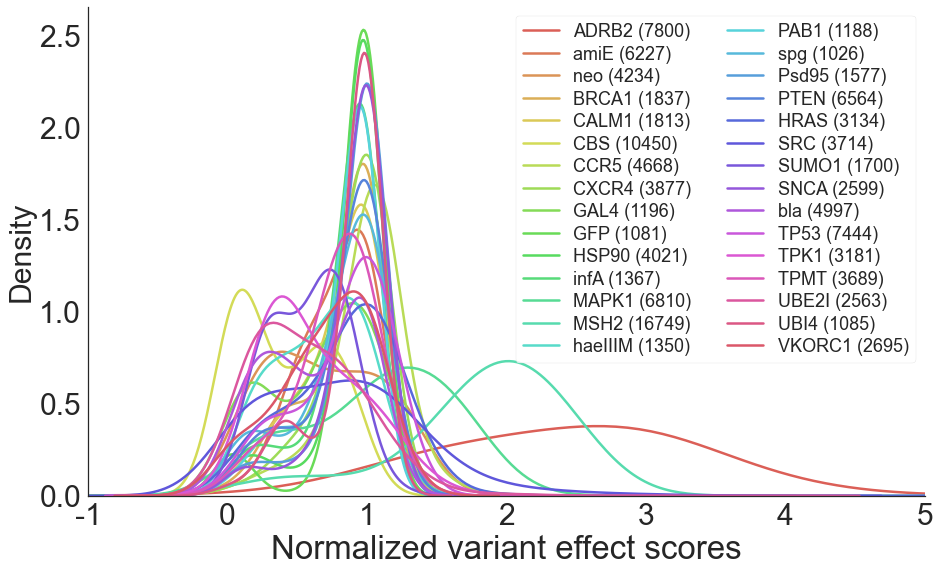

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 9)
sns.set_style("white")

colors = sns.color_palette("hls", 30)
i = 0
for dms in DB.dms_id.unique():
    prot = DB.loc[DB.dms_id == dms]['protein'].unique()[0]
    data = DB.loc[DB.dms_id == dms]["score_log_normalized"]
    ax = sns.kdeplot(data, bw_method=0.5, lw=2.5, color=colors[i], label=sum_db[sum_db.protein == prot]['name'].values[0])
    i += 1

plt.xlim(-1, 5)
ax.set_ylabel("Density", fontsize=30)
ax.set_xlabel("Normalized variant effect scores", fontsize=33)

# Set FixedLocator and FixedFormatter for y-axis
ax.yaxis.set_major_locator(plt.FixedLocator([0, 0.5, 1, 1.5, 2, 2.5]))
ax.yaxis.set_major_formatter(plt.FixedFormatter(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5']))
ax.tick_params(axis='y', labelsize=30)

# Set FixedLocator and FixedFormatter for x-axis
ax.xaxis.set_major_locator(plt.FixedLocator([-1, 0, 1, 2, 3, 4, 5]))
ax.xaxis.set_major_formatter(plt.FixedFormatter(['-1', '0', '1', '2', '3', '4', '5']))
ax.tick_params(axis='x', labelsize=30)

ax.legend(fontsize=18, ncol=2, labelspacing=0.25, frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

<div class="alert alert-success">
  <strong> <h1>Feature Importance with LASSO models</h1> </strong>
</div>

- For a range of alpha values, identify the best Lasso model.
- Using the best model, train Lasso and collect model coefficients from each protein-specific model
- Plot the coefficients collected from each protein-specific model for each feature

In [7]:
DB=DB.copy()

DB['score_log_normalized'] = DB['score_log_normalized'].round(3)

# structural features (7/9)
columns_to_update = ['colasi','fraction cons. 3D neighbor','fanc','fbnc','M.J. potential','access.dependent vol.','laar']

# Update structural features where 'pLDDT bin' is 0
DB.loc[DB['pLDDT bin'] == 0, columns_to_update] = 0.0

In [8]:
# model input
features = ['Blosum62', 'PSSM',"Shannon's entropy", "Shannon's entropy of seq. neighbours",'neco',
            'pLDDT','pLDDT bin', 'colasi', 'fraction cons. 3D neighbor', 'fanc', 'fbnc',
            'M.J. potential', 'access.dependent vol.', 'laar']

target = 'score_log_normalized'

alphas =  np.logspace(-5,2,30)

In [9]:
collect_df = PSP.LASSO_model(DB, features, target, alphas)

ADRB2       best alpha: 0.000010
amiE       best alpha: 0.000489
neo       best alpha: 0.000010
BRCA1       best alpha: 0.000281
CALM1       best alpha: 0.000161
CBS       best alpha: 0.000010
CCR5       best alpha: 0.002593
CXCR4       best alpha: 0.000853
GAL4       best alpha: 0.004520
GFP       best alpha: 0.004520
HSP90       best alpha: 0.004520
infA       best alpha: 0.002593
MAPK1       best alpha: 0.000010
MSH2       best alpha: 0.002593
haeIIIM       best alpha: 0.000161
PAB1       best alpha: 0.002593
spg       best alpha: 0.004520
Psd95       best alpha: 0.002593
PTEN       best alpha: 0.001487
HRAS       best alpha: 0.002593
SRC       best alpha: 0.002593
SUMO1       best alpha: 0.000853
SNCA       best alpha: 0.002593
bla       best alpha: 0.000489
TP53       best alpha: 0.000010
TPK1       best alpha: 0.000053
TPMT       best alpha: 0.000853
UBE2I       best alpha: 0.000092
UBI4       best alpha: 0.001487
VKORC1       best alpha: 0.001487


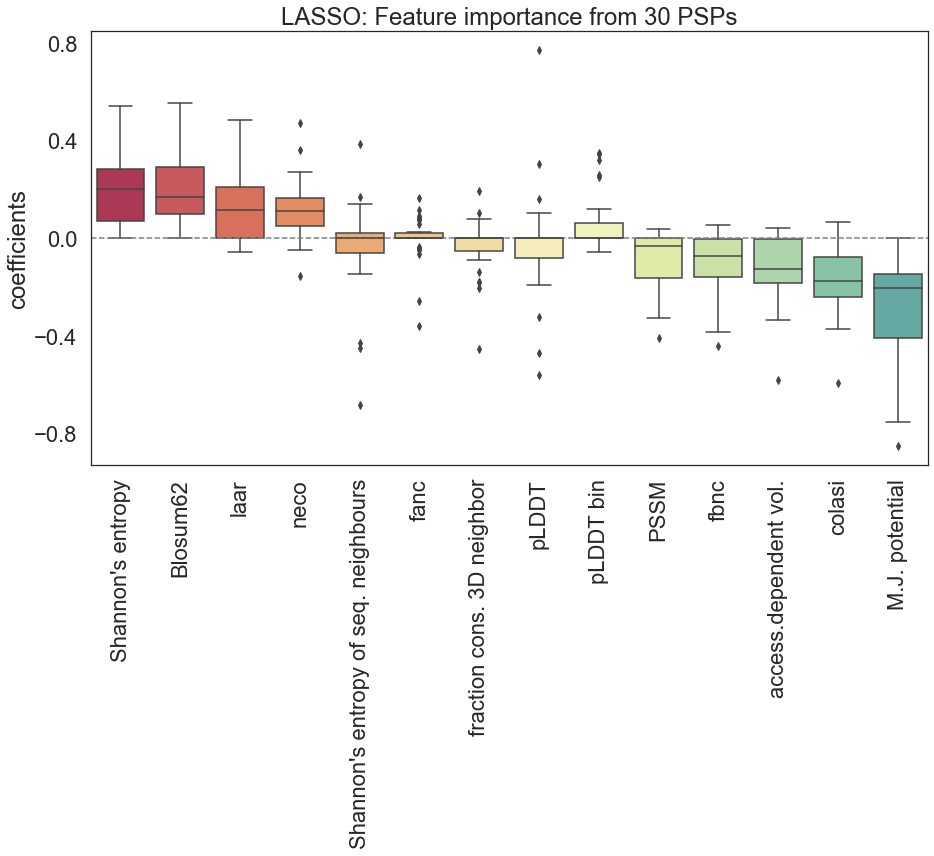

In [10]:
plt.figure(figsize=(15, 8))
sns.set(font_scale = 2)
sns.set_style("white")

grouped=collect_df.loc[:,['values','features']].groupby(['features']).median().sort_values(by='values', ascending=False)
ax = sns.boxplot(x="features", y="values", data=collect_df, order=grouped.index, palette=sns.color_palette("Spectral", 16))
ax = plt.xticks(rotation=90)
plt.axhline(y = 0, color = 'gray', linestyle = 'dashed')
txt= plt.title(f'LASSO: Feature importance from {len(collect_df.proteins.unique())} PSPs')

ax=plt.xlabel('')
ax=plt.ylabel('coefficients')
ax=plt.yticks([-0.8, -0.4, 0, 0.4, 0.8])
plt.show()

<div class="alert alert-info">
  <strong> <h1>Protein Specific Predictors (PSP) with leave-one-position-out (LOPO)</h1> </strong>
</div>

For each protein in the DMS assay dataframe, build a protein-specific predictor (PSP):
- build each model with multiple linear regression model
- use undersampling for training
- use leave-one-position-out (lopo) cross-validation method

Note: a log file for per protein is created in order to see the dataset imbalance & undersampling after the removal of each position

In [11]:
# Prepare dataframe

DB = pd.read_csv('data/Dataset_30proteins_features.csv')
DB=DB.copy()
DB['score_log_normalized'] = DB['score_log_normalized'].round(3)

# structural features (7/9)
columns_to_update = ['colasi','fraction cons. 3D neighbor','fanc','fbnc','M.J. potential','access.dependent vol.','laar']

# Update structural features where 'pLDDT bin' is 0
DB.loc[DB['pLDDT bin'] == 0, columns_to_update] = 0.0

In [12]:
# model input

features = ['Blosum62', 'PSSM',"Shannon's entropy", "Shannon's entropy of seq. neighbours",'neco',
            'pLDDT','pLDDT bin', 'colasi', 'fraction cons. 3D neighbor', 'fanc', 'fbnc',
            'M.J. potential', 'access.dependent vol.', 'laar']

target = 'score_log_normalized'
predictor_name = 'PSP_LOPO_undersampled_' + str(len(features))+'f'
undersample=True

path_log = 'output/log/'
save_data_path = 'data/'

In [13]:
%%time

coefs_dict = {}
DB_PREDICTED, stats_lopo = pd.DataFrame(), pd.DataFrame()

for uni in DB.uniprot.unique():
    db_protein = DB[DB.uniprot==uni].reset_index(drop=True)
    db_protein_predicted, stats, collect_coefs = PSP.MLR_LOPO_protein(db_protein, features, target, predictor_name, undersample, path_log)
    
    DB_PREDICTED = pd.concat([DB_PREDICTED,db_protein_predicted.reset_index(drop=True)])
    stats_lopo = pd.concat([stats_lopo, stats])
    
    # collecting coefficients of every position-specific model of every protein-specific model
    coefs_dict[db_protein.protein.unique()[0]] = collect_coefs

if len(DB) != len(DB_PREDICTED):
    sys.exit('DB lengths before/after do not match.')
    
stats_lopo.to_csv(save_data_path + 'stats_PSP_LOPO_'+ str(len(features))+'.csv')

Model with undersampling...
ADRB2
pearson: 0.5, spearman: 0.52
__________________________


Model with undersampling...
amiE
pearson: 0.6, spearman: 0.64
__________________________


Model with undersampling...
neo
pearson: 0.68, spearman: 0.68
__________________________


Model with undersampling...
BRCA1
pearson: 0.53, spearman: 0.52
__________________________


Model with undersampling...
CALM1
pearson: 0.32, spearman: 0.3
__________________________


Model with undersampling...
CBS
pearson: 0.59, spearman: 0.62
__________________________


Model with undersampling...
CCR5
pearson: 0.42, spearman: 0.38
__________________________


Model with undersampling...
CXCR4
pearson: 0.36, spearman: 0.32
__________________________


Model with undersampling...
GAL4
pearson: 0.4, spearman: 0.46
__________________________


Model with undersampling...
GFP
pearson: 0.49, spearman: 0.48
__________________________


Model with undersampling...
HSP90
pearson: 0.39, spearman: 0.44
___________________

In [14]:
stats_lopo

,protein,model,pearson,spearman
0,ADRB2,PSP_LOPO_undersampled_14f,0.50,0.52
0,amiE,PSP_LOPO_undersampled_14f,0.60,0.64
0,neo,PSP_LOPO_undersampled_14f,0.68,0.68
0,BRCA1,PSP_LOPO_undersampled_14f,0.53,0.52
0,CALM1,PSP_LOPO_undersampled_14f,0.32,0.30
0,CBS,PSP_LOPO_undersampled_14f,0.59,0.62
0,CCR5,PSP_LOPO_undersampled_14f,0.42,0.38
0,CXCR4,PSP_LOPO_undersampled_14f,0.36,0.32
0,GAL4,PSP_LOPO_undersampled_14f,0.40,0.46
0,GFP,PSP_LOPO_undersampled_14f,0.49,0.48


<div class="alert alert-success">
  <strong> <h1>Visualization of Gaussian Mixture Models & thresholds </h1> </strong>
</div>

Gaussian Mixture model is used to identify the optimal threshold separating the two peaks in protein datasets, in order to undersample the majority group

The thresholds obtained with GMM can be visualized using the following function

In [15]:
def plotGMM(plot_files, prot):

    gmm, X,x, y1,y2, w1,w2, idxs = [plot_files[x] for x in range(len(plot_files))]
    print(idxs)

    plt.figure(figsize=[7,5])
    plt.rcParams['font.size'] = 15
    sns.set(font_scale = 2)
    sns.set_style("white")
    ax=plt.subplot()

    # Plot data histogram
    ax.hist(X, bins= 30, density=True, histtype='stepfilled', alpha=0.35, label ='Data')

    # Plot pdf of whole model
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    ax.plot(x, pdf, '-k', label='whole model')

    ax.plot(x,y1*w1,color='red',label='line1', alpha=0.5, linewidth=4, linestyle='--')
    ax.plot(x,y2*w2,color='blue',label='line2',alpha=0.5,linewidth=4, linestyle='--')

    for i in idxs:
        ax.axvline(x[i], color='black', ls="--", alpha=0.7)
        ax.text(x[i], ax.get_ylim()[1] + 0.05, f"{x[i]:.2f}", ha='center', va='bottom', fontsize=20)

    ax.set(xlabel='normalized functional assay scores',ylabel='density')
    plt.title(prot+'\n')
    plt.ylim(0,3.25)

    plt.show()

[584]


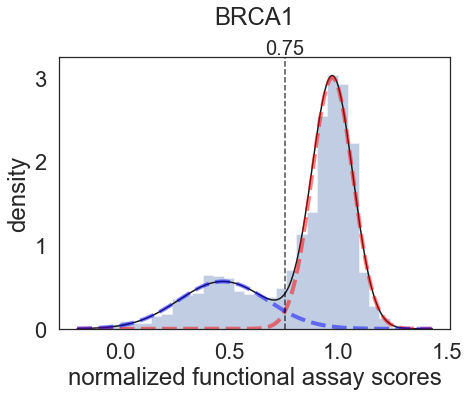

In [16]:
prot = 'BRCA1'
threshold_prot,_ = PSP.GMM_interaction(DB[DB.protein==prot],plot=True)
plotGMM(_, prot)

<div class="alert alert-success">
  <strong> <h1>Visualization of Protein Specific Predictor Performances </h1> </strong>
</div>

In [17]:
stats_lopo = stats_lopo.sort_values(by='pearson', ascending=True).reset_index(drop=True)

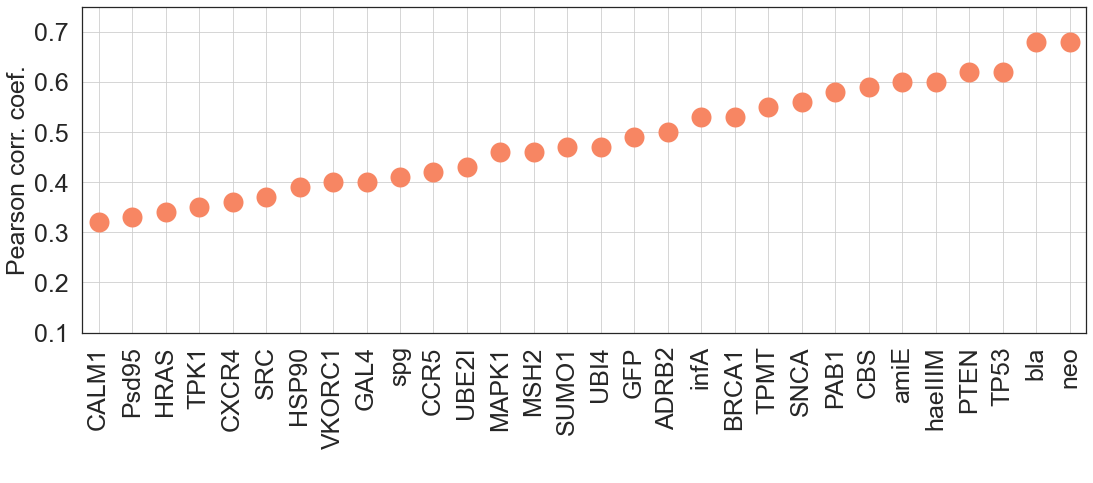

In [18]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.set(font_scale=2)
sns.set_style("white")

ax1 = sns.swarmplot(data=stats_lopo, x='protein', y='pearson', s=20, marker='o', color='#f78663', label='MLR LOPO')

plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel(' ')
plt.ylim(0.1, 0.75)
plt.yticks(np.arange(0.1, 0.75, 0.1))
plt.grid(which='both', alpha=0.8)

plt.ylabel("Pearson corr. coef.", fontsize=25)

plt.legend('')

<div class="alert alert-info">
  <strong> <h1>Cross Predictions</h1> </strong>
</div>

- Train one PSP, predict remaining 29 proteins, save the 29 different prediction outputs of a single PSP in the "train_one_predict_rest" folder
- In the a "tested_protein_csv" folder, each csv file is the collection of predictions coming from 29 different PSPs for a single protein

In [19]:
# Prepare dataframe

DB = pd.read_csv('data/Dataset_30proteins_features.csv')
DB=DB.copy()
DB['score_log_normalized'] = DB['score_log_normalized'].round(3)

# structural features (7/9)
columns_to_update = ['colasi','fraction cons. 3D neighbor','fanc','fbnc','M.J. potential','access.dependent vol.','laar']

# Update structural features where 'pLDDT bin' is 0
DB.loc[DB['pLDDT bin'] == 0, columns_to_update] = 0.0

In [20]:
# model input

features = ['Blosum62', 'PSSM',"Shannon's entropy", "Shannon's entropy of seq. neighbours",'neco',
            'pLDDT','pLDDT bin', 'colasi', 'fraction cons. 3D neighbor', 'fanc', 'fbnc',
            'M.J. potential', 'access.dependent vol.', 'laar']

target = 'score_log_normalized'
predictor_name = 'PSP_LOPO_undersampled_' + str(len(features))+'f'
undersample=True

path_log = 'output/log/'
path_save = 'output/PSP/train_one_predict_rest/'

In [21]:
prot_list = DB.protein.unique()
len(prot_list)

30

In [22]:
cross_predictions = PSP.Cross_Predictions_MLR(DB, prot_list, path_save, path_log, predictor_name, features, target, undersample)
cross_predictions.to_csv('data/stats_PSP_cross_preds.csv', index=0)

       PROTEIN training: ADRB2 7800
testing... amiE
amiE
pearson: 0.55, spearman: 0.59
__________________________


testing... neo
neo
pearson: 0.63, spearman: 0.64
__________________________


testing... BRCA1
BRCA1
pearson: 0.51, spearman: 0.48
__________________________


testing... CALM1
CALM1
pearson: 0.24, spearman: 0.22
__________________________


testing... CBS
CBS
pearson: 0.54, spearman: 0.57
__________________________


testing... CCR5
CCR5
pearson: 0.36, spearman: 0.35
__________________________


testing... CXCR4
CXCR4
pearson: 0.27, spearman: 0.24
__________________________


testing... GAL4
GAL4
pearson: 0.3, spearman: 0.3
__________________________


testing... GFP
GFP
pearson: 0.47, spearman: 0.52
__________________________


testing... HSP90
HSP90
pearson: 0.31, spearman: 0.28
__________________________


testing... infA
infA
pearson: 0.44, spearman: 0.35
__________________________


testing... MAPK1
MAPK1
pearson: 0.3, spearman: 0.3
__________________________


test

GFP
pearson: 0.49, spearman: 0.55
__________________________


testing... HSP90
HSP90
pearson: 0.39, spearman: 0.42
__________________________


testing... infA
infA
pearson: 0.51, spearman: 0.43
__________________________


testing... MAPK1
MAPK1
pearson: 0.43, spearman: 0.42
__________________________


testing... MSH2
MSH2
pearson: 0.42, spearman: 0.35
__________________________


testing... haeIIIM
haeIIIM
pearson: 0.59, spearman: 0.59
__________________________


testing... PAB1
PAB1
pearson: 0.5, spearman: 0.55
__________________________


testing... spg
spg
pearson: 0.4, spearman: 0.41
__________________________


testing... Psd95
Psd95
pearson: 0.41, spearman: 0.45
__________________________


testing... PTEN
PTEN
pearson: 0.61, spearman: 0.54
__________________________


testing... HRAS
HRAS
pearson: 0.31, spearman: 0.3
__________________________


testing... SRC
SRC
pearson: 0.31, spearman: 0.38
__________________________


testing... SUMO1
SUMO1
pearson: 0.51, spearman: 0.51

PTEN
pearson: 0.52, spearman: 0.45
__________________________


testing... HRAS
HRAS
pearson: 0.33, spearman: 0.33
__________________________


testing... SRC
SRC
pearson: 0.17, spearman: 0.2
__________________________


testing... SUMO1
SUMO1
pearson: 0.41, spearman: 0.4
__________________________


testing... SNCA
SNCA
pearson: 0.14, spearman: 0.09
__________________________


testing... bla
bla
pearson: 0.49, spearman: 0.49
__________________________


testing... TP53
TP53
pearson: 0.53, spearman: 0.47
__________________________


testing... TPK1
TPK1
pearson: 0.31, spearman: 0.34
__________________________


testing... TPMT
TPMT
pearson: 0.46, spearman: 0.44
__________________________


testing... UBE2I
UBE2I
pearson: 0.32, spearman: 0.38
__________________________


testing... UBI4
UBI4
pearson: 0.34, spearman: 0.25
__________________________


testing... VKORC1
VKORC1
pearson: 0.35, spearman: 0.35
__________________________


       PROTEIN training: CXCR4 3877
testing... ADRB2
A

testing... UBI4
UBI4
pearson: 0.36, spearman: 0.32
__________________________


testing... VKORC1
VKORC1
pearson: 0.31, spearman: 0.31
__________________________


       PROTEIN training: HSP90 4021
testing... ADRB2
ADRB2
pearson: 0.45, spearman: 0.48
__________________________


testing... amiE
amiE
pearson: 0.54, spearman: 0.59
__________________________


testing... neo
neo
pearson: 0.59, spearman: 0.6
__________________________


testing... BRCA1
BRCA1
pearson: 0.5, spearman: 0.46
__________________________


testing... CALM1
CALM1
pearson: 0.2, spearman: 0.19
__________________________


testing... CBS
CBS
pearson: 0.55, spearman: 0.59
__________________________


testing... CCR5
CCR5
pearson: 0.38, spearman: 0.36
__________________________


testing... CXCR4
CXCR4
pearson: 0.18, spearman: 0.15
__________________________


testing... GAL4
GAL4
pearson: 0.32, spearman: 0.31
__________________________


testing... GFP
GFP
pearson: 0.38, spearman: 0.43
__________________________


t

testing... CCR5
CCR5
pearson: 0.38, spearman: 0.36
__________________________


testing... CXCR4
CXCR4
pearson: 0.26, spearman: 0.21
__________________________


testing... GAL4
GAL4
pearson: 0.34, spearman: 0.36
__________________________


testing... GFP
GFP
pearson: 0.53, spearman: 0.54
__________________________


testing... HSP90
HSP90
pearson: 0.37, spearman: 0.37
__________________________


testing... infA
infA
pearson: 0.54, spearman: 0.4
__________________________


testing... MAPK1
MAPK1
pearson: 0.41, spearman: 0.38
__________________________


testing... haeIIIM
haeIIIM
pearson: 0.58, spearman: 0.58
__________________________


testing... PAB1
PAB1
pearson: 0.57, spearman: 0.6
__________________________


testing... spg
spg
pearson: 0.38, spearman: 0.34
__________________________


testing... Psd95
Psd95
pearson: 0.44, spearman: 0.43
__________________________


testing... PTEN
PTEN
pearson: 0.61, spearman: 0.54
__________________________


testing... HRAS
HRAS
pearson: 0.

PTEN
pearson: -0.26, spearman: -0.23
__________________________


testing... HRAS
HRAS
pearson: 0.09, spearman: 0.13
__________________________


testing... SRC
SRC
pearson: -0.11, spearman: -0.11
__________________________


testing... SUMO1
SUMO1
pearson: 0.12, spearman: 0.16
__________________________


testing... SNCA
SNCA
pearson: -0.21, spearman: -0.12
__________________________


testing... bla
bla
pearson: 0.22, spearman: 0.21
__________________________


testing... TP53
TP53
pearson: -0.38, spearman: -0.39
__________________________


testing... TPK1
TPK1
pearson: 0.03, spearman: 0.02
__________________________


testing... TPMT
TPMT
pearson: -0.12, spearman: -0.13
__________________________


testing... UBE2I
UBE2I
pearson: 0.13, spearman: 0.13
__________________________


testing... UBI4
UBI4
pearson: 0.21, spearman: 0.13
__________________________


testing... VKORC1
VKORC1
pearson: 0.01, spearman: 0.01
__________________________


       PROTEIN training: Psd95 1577
testin

UBI4
pearson: 0.48, spearman: 0.41
__________________________


testing... VKORC1
VKORC1
pearson: 0.27, spearman: 0.29
__________________________


       PROTEIN training: SRC 3714
testing... ADRB2
ADRB2
pearson: 0.42, spearman: 0.44
__________________________


testing... amiE
amiE
pearson: 0.53, spearman: 0.58
__________________________


testing... neo
neo
pearson: 0.57, spearman: 0.57
__________________________


testing... BRCA1
BRCA1
pearson: 0.41, spearman: 0.41
__________________________


testing... CALM1
CALM1
pearson: 0.17, spearman: 0.16
__________________________


testing... CBS
CBS
pearson: 0.52, spearman: 0.55
__________________________


testing... CCR5
CCR5
pearson: 0.26, spearman: 0.26
__________________________


testing... CXCR4
CXCR4
pearson: 0.12, spearman: 0.1
__________________________


testing... GAL4
GAL4
pearson: 0.33, spearman: 0.33
__________________________


testing... GFP
GFP
pearson: 0.43, spearman: 0.44
__________________________


testing... HSP90


CBS
pearson: 0.54, spearman: 0.58
__________________________


testing... CCR5
CCR5
pearson: 0.35, spearman: 0.32
__________________________


testing... CXCR4
CXCR4
pearson: 0.25, spearman: 0.21
__________________________


testing... GAL4
GAL4
pearson: 0.37, spearman: 0.4
__________________________


testing... GFP
GFP
pearson: 0.5, spearman: 0.55
__________________________


testing... HSP90
HSP90
pearson: 0.33, spearman: 0.3
__________________________


testing... infA
infA
pearson: 0.51, spearman: 0.38
__________________________


testing... MAPK1
MAPK1
pearson: 0.4, spearman: 0.38
__________________________


testing... MSH2
MSH2
pearson: 0.44, spearman: 0.36
__________________________


testing... haeIIIM
haeIIIM
pearson: 0.59, spearman: 0.6
__________________________


testing... PAB1
PAB1
pearson: 0.52, spearman: 0.55
__________________________


testing... spg
spg
pearson: 0.42, spearman: 0.41
__________________________


testing... Psd95
Psd95
pearson: 0.4, spearman: 0.44
__

haeIIIM
pearson: 0.58, spearman: 0.58
__________________________


testing... PAB1
PAB1
pearson: 0.58, spearman: 0.6
__________________________


testing... spg
spg
pearson: 0.39, spearman: 0.33
__________________________


testing... Psd95
Psd95
pearson: 0.39, spearman: 0.39
__________________________


testing... PTEN
PTEN
pearson: 0.61, spearman: 0.52
__________________________


testing... HRAS
HRAS
pearson: 0.34, spearman: 0.31
__________________________


testing... SRC
SRC
pearson: 0.27, spearman: 0.31
__________________________


testing... SUMO1
SUMO1
pearson: 0.45, spearman: 0.43
__________________________


testing... SNCA
SNCA
pearson: 0.16, spearman: 0.11
__________________________


testing... bla
bla
pearson: 0.65, spearman: 0.67
__________________________


testing... TP53
TP53
pearson: 0.55, spearman: 0.45
__________________________


testing... TPK1
TPK1
pearson: 0.27, spearman: 0.29
__________________________


testing... UBE2I
UBE2I
pearson: 0.41, spearman: 0.47
___

bla
pearson: 0.6, spearman: 0.6
__________________________


testing... TP53
TP53
pearson: 0.46, spearman: 0.35
__________________________


testing... TPK1
TPK1
pearson: 0.28, spearman: 0.31
__________________________


testing... TPMT
TPMT
pearson: 0.5, spearman: 0.46
__________________________


testing... UBE2I
UBE2I
pearson: 0.36, spearman: 0.41
__________________________


testing... UBI4
UBI4
pearson: 0.5, spearman: 0.38
__________________________




In [23]:
path_save_trained = 'output/PSP/train_one_predict_rest/'
path_save_tested = 'output/PSP/tested_protein_csv/'
prot_list = DB.protein.unique()

In [24]:
# prepare per predicted csv files
PSP.tested_protein_csvs(DB, prot_list, target,predictor_name, path_save_trained, path_save_tested)

test protein: ADRB2 // collect preds. from:(29, ['amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1'])

test protein: amiE // collect preds. from:(29, ['ADRB2', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1'])

test protein: neo // collect preds. from:(29, ['ADRB2', 'amiE', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1'])

test protein: BRCA1 // collect preds. from:(29, ['ADRB2', 'amiE', 'neo', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 

test protein: VKORC1 // collect preds. from:(29, ['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4'])



<div class="alert alert-info">
  <strong> <h1>Determining the ten most effective predictors for the QAFI predictor</h1> </strong>
</div>

Selecting the 10 best predictors for protein X using leave-one-protein-out method:

Round 1: 
- train protein A, predict values of the remaining 28 proteins separately, calculate pearson's coefficients for each performance
- take the <strong>median of 28 pearson's correlations</strong>, which now represents the "performance of PSP-A"
- repeat this process for all 29 proteins, and collect the performance of each PSP


Round 2: 
- Rank the PSPs by their performances, and select the top 10 proteins
- Use these 10 PSPs to separately predict the functional assay values of protein X (10 different predictions are obtained for the variants of protein X)
- Take the median of their predictions per variant, and obtain the final prediction outcome <strong>= QAFI predictions</strong>

In [25]:
DB = pd.read_csv('data/Dataset_30proteins_features.csv')
cross_predictions = pd.read_csv('data/stats_PSP_cross_preds.csv')

In [26]:
predictor_name = cross_predictions.model.unique()[0]
target = 'score_log_normalized'
proteins_to_be_tested = list(DB.protein.unique())
howmany = 10

path_save_tested = 'output/PSP/tested_protein_csv/'

In [27]:
stats_table = PSP.function_cross_preds_median(path_save_tested, cross_predictions, predictor_name, target, proteins_to_be_tested, howmany)


PSP_LOPO_undersampled_14f....


___________________________________________________________________________
:::::::ROUND 1::::::: 
 we are going to find who are the best 10 predictors for predicting ADRB2
___________________________________________________________________________


TRAIN: amiE
TESTED:['neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42
_____________

TRAIN: neo
TESTED:['amiE', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.425
_____________

TRAIN: BRCA1
TESTED:['amiE', 'neo', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PA

_________________________________________________________________

- - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - -


___________________________________________________________________________
:::::::ROUND 1::::::: 
 we are going to find who are the best 10 predictors for predicting amiE
___________________________________________________________________________


TRAIN: ADRB2
TESTED:['neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.43
_____________

TRAIN: neo
TESTED:['ADRB2', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.425
_____________

T


Median of pearsons: 0.43
_____________

TRAIN: amiE
TESTED:['ADRB2', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42
_____________

TRAIN: BRCA1
TESTED:['ADRB2', 'amiE', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.425
_____________

TRAIN: CALM1
TESTED:['ADRB2', 'amiE', 'BRCA1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.34
_____________

TRAIN: CBS
TESTED:['ADRB2', 'amiE', 'BRCA1', 'CALM1', 'CCR5', 'CXCR4', 'GAL4


Median of pearsons: 0.425
_____________

TRAIN: CALM1
TESTED:['ADRB2', 'amiE', 'neo', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.34
_____________

TRAIN: CBS
TESTED:['ADRB2', 'amiE', 'neo', 'CALM1', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.395
_____________

TRAIN: CCR5
TESTED:['ADRB2', 'amiE', 'neo', 'CALM1', 'CBS', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.345
_____________

TRAIN: CXCR4
TESTED:['ADRB2', 'amiE', 'neo', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GF


Median of pearsons: 0.33
_____________

TRAIN: GAL4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.10500000000000001
_____________

TRAIN: GFP
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42
_____________

TRAIN: HSP90
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.39
_____________

TRAIN: infA
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CBS', 'CCR5', 


Median of pearsons: 0.4
_____________

TRAIN: MSH2
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.46499999999999997
_____________

TRAIN: haeIIIM
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.44
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.315
_____________

TRAIN: spg
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', '

Median of pearsons: 0.39
_____________

TRAIN: infA
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.31
_____________

TRAIN: MAPK1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42000000000000004
_____________

TRAIN: MSH2
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.49
_____________

TRAIN: haeIIIM
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', '


Median of pearsons: 0.31
_____________

TRAIN: MAPK1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GFP', 'HSP90', 'infA', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42000000000000004
_____________

TRAIN: MSH2
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.49
_____________

TRAIN: haeIIIM
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS'


Median of pearsons: 0.335
_____________

TRAIN: spg
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: -0.045000000000000005
_____________

TRAIN: Psd95
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.315
_____________

TRAIN: PTEN
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.45999999999999996
_____________

TRAIN: HRAS
TESTED:['ADRB2', 'amiE', 'neo', 'B

Median of pearsons: 0.365
_____________

TRAIN: SRC
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.4
_____________

TRAIN: SUMO1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.425
_____________

TRAIN: SNCA
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.245
_____________

TRAIN: bla
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 


Median of pearsons: 0.375
_____________

TRAIN: TPMT
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: UBE2I
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBI4', 'VKORC1']

Median of pearsons: 0.28
_____________

TRAIN: UBI4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'VKORC1']

Median of pearsons: 0.02
_____________

TRAIN: VKORC1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'C

Median of pearsons: 0.28
_____________

TRAIN: UBI4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'VKORC1']

Median of pearsons: 0.01
_____________

TRAIN: VKORC1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4']

Median of pearsons: 0.415
_____________

best predictors for infA are: ['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'BRCA1' 'TPMT' 'TP53' 'bla' 'SUMO1']

___________________________________________________________________________
:::::::ROUND 2::::::: 
 we are going to predict infA using median of ['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'BRCA1' 'TPMT' 'TP53' 'bla' 'SUMO1']
_____________________________________________

output column name: // QAFI(PSP_median_10) // 

median of 10 predictions: r = 0.4, rho = 0.38
_________________________________________________________________

- - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - -


___________________________________________________________________________
:::::::ROUND 1::::::: 
 we are going to find who are the best 10 predictors for predicting MSH2
___________________________________________________________________________


TRAIN: ADRB2
TESTED:['amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.43
_____________

TRAIN: amiE
TESTED:['ADRB2', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 

output column name: // QAFI(PSP_median_10) // 

median of 10 predictions: r = 0.45, rho = 0.36
_________________________________________________________________

- - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - -


___________________________________________________________________________
:::::::ROUND 1::::::: 
 we are going to find who are the best 10 predictors for predicting haeIIIM
___________________________________________________________________________


TRAIN: ADRB2
TESTED:['amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.43
_____________

TRAIN: amiE
TESTED:['ADRB2', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'T


Median of pearsons: 0.345
_____________

TRAIN: CXCR4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.33
_____________

TRAIN: GAL4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.10500000000000001
_____________

TRAIN: GFP
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.41
_____________

TRAIN: HSP90
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', '

Median of pearsons: 0.44
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.335
_____________

TRAIN: Psd95
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.315
_____________

TRAIN: PTEN
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'Psd95', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.45999999999999996
_____________

TRAIN: HRAS
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1',


Median of pearsons: 0.305
_____________

TRAIN: MAPK1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42000000000000004
_____________

TRAIN: MSH2
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.49
_____________

TRAIN: haeIIIM
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS


Median of pearsons: 0.345
_____________

TRAIN: SRC
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.4
_____________

TRAIN: SUMO1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'HRAS', 'SRC', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.425
_____________

TRAIN: SNCA
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'HRAS', 'SRC', 'SUMO1', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.24
_____________

TRAIN: bla
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CX


Median of pearsons: 0.405
_____________

TRAIN: SUMO1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'SRC', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.435
_____________

TRAIN: SNCA
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'SRC', 'SUMO1', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.245
_____________

TRAIN: bla
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'SRC', 'SUMO1', 'SNCA', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.435
_____________

TRAIN: TP53
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5',


Median of pearsons: 0.375
_____________

TRAIN: TPMT
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: UBE2I
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBI4', 'VKORC1']

Median of pearsons: 0.30000000000000004
_____________

TRAIN: UBI4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'VKORC1']

Median of pearsons: 0.02
_____________

TRAIN: VKORC1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM

_________________________________________________________________

- - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - -


___________________________________________________________________________
:::::::ROUND 1::::::: 
 we are going to find who are the best 10 predictors for predicting SNCA
___________________________________________________________________________


TRAIN: ADRB2
TESTED:['amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.44
_____________

TRAIN: amiE
TESTED:['ADRB2', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.44
_____________

TR


Median of pearsons: 0.345
_____________

TRAIN: CXCR4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.33
_____________

TRAIN: GAL4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.10500000000000001
_____________

TRAIN: GFP
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.41
_____________

TRAIN: HSP90
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1'


Median of pearsons: 0.31
_____________

TRAIN: MAPK1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.42000000000000004
_____________

TRAIN: MSH2
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.46499999999999997
_____________

TRAIN: haeIIIM
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TPK1', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.44
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1


Median of pearsons: 0.445
_____________

TRAIN: PAB1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.335
_____________

TRAIN: spg
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: -0.045000000000000005
_____________

TRAIN: Psd95
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPMT', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.315
_____________

TRAIN: PTEN
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1'


Median of pearsons: 0.29000000000000004
_____________

TRAIN: PTEN
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: HRAS
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.345
_____________

TRAIN: SRC
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBE2I', 'UBI4', 'VKORC1']

Median of pearsons: 0.4
_____________

TRAIN: SUMO1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', '


Median of pearsons: 0.44
_____________

TRAIN: TPK1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPMT', 'UBI4', 'VKORC1']

Median of pearsons: 0.375
_____________

TRAIN: TPMT
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'UBI4', 'VKORC1']

Median of pearsons: 0.445
_____________

TRAIN: UBI4
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'VKORC1']

Median of pearsons: 0.01
_____________

TRAIN: VKORC1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CCR5', 'C


Median of pearsons: 0.45
_____________

TRAIN: BRCA1
TESTED:['ADRB2', 'amiE', 'neo', 'CALM1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4']

Median of pearsons: 0.43
_____________

TRAIN: CALM1
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CBS', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4']

Median of pearsons: 0.345
_____________

TRAIN: CBS
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CCR5', 'CXCR4', 'GAL4', 'GFP', 'HSP90', 'infA', 'MAPK1', 'MSH2', 'haeIIIM', 'PAB1', 'spg', 'Psd95', 'PTEN', 'HRAS', 'SRC', 'SUMO1', 'SNCA', 'bla', 'TP53', 'TPK1', 'TPMT', 'UBE2I', 'UBI4']

Median of pearsons: 0.4
_____________

TRAIN: CCR5
TESTED:['ADRB2', 'amiE', 'neo', 'BRCA1', 'CALM1', 'CBS', 'CXCR4', 'GAL4', 

In [28]:
stats_table

,tested_protein,MedianModel,pearson,spearman,median_of_which_proteins
0,ADRB2,QAFI(PSP_median_10),0.49,0.52,['MSH2' 'PTEN' 'haeIIIM' 'BRCA1' 'TPMT' 'TP53'...
1,amiE,QAFI(PSP_median_10),0.56,0.62,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'BRCA1' 'TPMT...
2,neo,QAFI(PSP_median_10),0.67,0.67,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'BRCA1' 'TPMT...
3,BRCA1,QAFI(PSP_median_10),0.55,0.51,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'TPMT' ...
4,CALM1,QAFI(PSP_median_10),0.27,0.24,['MSH2' 'PTEN' 'neo' 'TPMT' 'haeIIIM' 'ADRB2' ...
5,CBS,QAFI(PSP_median_10),0.55,0.59,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'BRCA1'...
6,CCR5,QAFI(PSP_median_10),0.37,0.35,['MSH2' 'PTEN' 'neo' 'TPMT' 'haeIIIM' 'ADRB2' ...
7,CXCR4,QAFI(PSP_median_10),0.26,0.21,['MSH2' 'PTEN' 'neo' 'TPMT' 'haeIIIM' 'ADRB2' ...
8,GAL4,QAFI(PSP_median_10),0.34,0.36,['MSH2' 'PTEN' 'neo' 'TPMT' 'haeIIIM' 'ADRB2' ...
9,GFP,QAFI(PSP_median_10),0.49,0.54,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'BRCA1'...


In [29]:
stats_table.to_csv('data/stats_QAFI.csv')

## List of 10 most repeated proteins in the cross-predictions are selected for the final QAFI

In [30]:
input_array = stats_table['median_of_which_proteins'].values
protein_counts=PSP.count_protein_occurrences(input_array)

In [31]:
protein_counts.head(10)

,protein,count
0,haeIIIM,29
1,MSH2,29
2,TP53,29
3,neo,29
4,PTEN,29
5,ADRB2,29
6,TPMT,29
7,bla,29
8,SUMO1,28
9,amiE,21


In [32]:
protein_counts.head(10).to_csv('data/QAFI_10proteins_list.csv', index=0)

<div class="alert alert-success">
  <strong> <h1>Visualization of PSP vs QAFI </h1> </strong>
</div>

In [33]:
psp = pd.read_csv('data/stats_PSP_LOPO_14.csv', index_col=0)
psp = psp.sort_values(by='pearson', ascending=True).reset_index(drop=True)
psp.rename(columns={'pearson':'pearson_psp', 'spearman':'spearman_psp'}, inplace=True)
psp.head()

,protein,model,pearson_psp,spearman_psp
0,CALM1,PSP_LOPO_undersampled_14f,0.32,0.30
1,Psd95,PSP_LOPO_undersampled_14f,0.33,0.37
2,HRAS,PSP_LOPO_undersampled_14f,0.34,0.35
3,TPK1,PSP_LOPO_undersampled_14f,0.35,0.38
4,CXCR4,PSP_LOPO_undersampled_14f,0.36,0.32


In [34]:
qafi = pd.read_csv('data/stats_QAFI.csv', index_col=0)
qafi.rename(columns={'pearson':'pearson_qafi', 'spearman':'spearman_qafi','tested_protein':'protein'}, inplace=True)
qafi.head()

,protein,MedianModel,pearson_qafi,spearman_qafi,median_of_which_proteins
0,ADRB2,QAFI(PSP_median_10),0.49,0.52,['MSH2' 'PTEN' 'haeIIIM' 'BRCA1' 'TPMT' 'TP53'...
1,amiE,QAFI(PSP_median_10),0.56,0.62,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'BRCA1' 'TPMT...
2,neo,QAFI(PSP_median_10),0.67,0.67,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'BRCA1' 'TPMT...
3,BRCA1,QAFI(PSP_median_10),0.55,0.51,['MSH2' 'PTEN' 'haeIIIM' 'ADRB2' 'neo' 'TPMT' ...
4,CALM1,QAFI(PSP_median_10),0.27,0.24,['MSH2' 'PTEN' 'neo' 'TPMT' 'haeIIIM' 'ADRB2' ...


In [35]:
merged = psp[['protein','pearson_psp','spearman_psp']].merge(qafi[['protein','pearson_qafi','spearman_qafi']], on=['protein'], how='left')
merged.head()

,protein,pearson_psp,spearman_psp,pearson_qafi,spearman_qafi
0,CALM1,0.32,0.30,0.27,0.24
1,Psd95,0.33,0.37,0.41,0.42
2,HRAS,0.34,0.35,0.35,0.33
3,TPK1,0.35,0.38,0.27,0.29
4,CXCR4,0.36,0.32,0.26,0.21


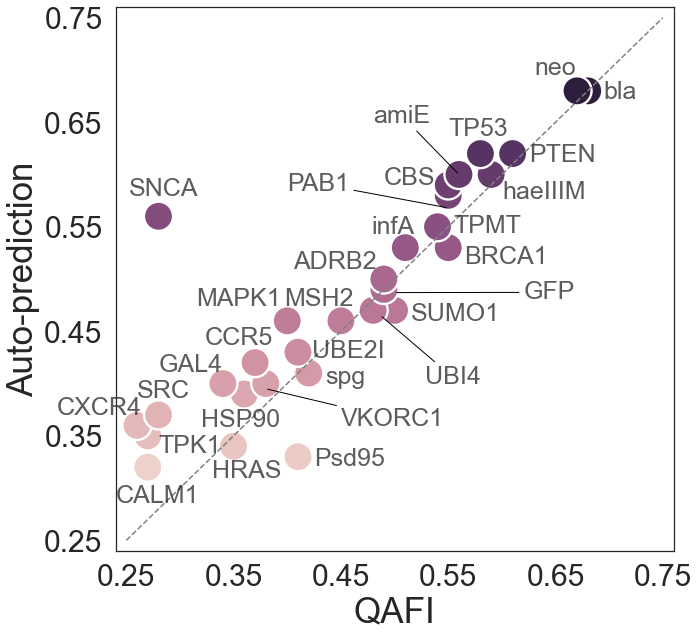

In [36]:
labels = list(merged.protein.values)

plt.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
sns.set_style("white")

ax = sns.scatterplot(x='pearson_qafi',y='pearson_psp',data=merged,marker='o', s=850,hue='pearson_psp')
plt.legend([],frameon=False)
plt.xticks([0.25,0.35,0.45,0.55,0.65,0.75], fontsize=30)
plt.yticks([0.25,0.35,0.45,0.55,0.65,0.75], fontsize=30)
plt.margins(0.02)
plt.ylabel('Auto-prediction', fontsize=35)
plt.xlabel('QAFI', fontsize=35)

plt.plot([0.25, 0.75], [0.25, 0.75], ls="--", c="gray")

# Annotations
annotations = [
    (0.24, 0.286, 'CALM1'),
    (0.425, 0.322, 'Psd95'),
    (0.33, 0.31, 'HRAS'),
    (0.28, 0.334, 'TPK1'),
    (0.185, 0.37, 'CXCR4'),
    (0.26, 0.387, 'SRC'),
    (0.32, 0.359, 'HSP90'),
    (0.38, 0.395, 'VKORC1', 0.45, 0.36),
    (0.28, 0.412, 'GAL4'),
    (0.435, 0.4, 'spg'),
    (0.323, 0.437, 'CCR5'),
    (0.423, 0.425, 'UBE2I'),
    (0.315, 0.475, 'MAPK1'),
    (0.397, 0.475, 'MSH2'),
    (0.515, 0.46, 'SUMO1'),
    (0.487, 0.465, 'UBI4', 0.528, 0.4),
    (0.5, 0.487, 'GFP', 0.62, 0.481),
    (0.405, 0.51, 'ADRB2'),
    (0.478, 0.544, 'infA'),
    (0.565, 0.515, 'BRCA1'),
    (0.555, 0.545, 'TPMT'),
    (0.252, 0.58, 'SNCA'),
    (0.55, 0.568, 'PAB1', 0.4, 0.585),
    (0.49, 0.59, 'CBS'),
    (0.56, 0.6, 'amiE', 0.48, 0.65),
    (0.6, 0.577, 'haeIIIM'),
    (0.625, 0.612, 'PTEN'),
    (0.55, 0.637, 'TP53'),
    (0.695, 0.673, 'bla'),
    (0.63, 0.696, 'neo')]

for ann in annotations:
    if len(ann) == 3:
        ax.text(ann[0], ann[1], ann[2], fontsize=25, alpha=0.75)
    elif len(ann) == 5:
        ax.annotate(ann[2], (ann[0], ann[1]), xytext=(ann[3], ann[4]),
                    arrowprops=dict(arrowstyle='-', color='black'), fontsize=25, alpha=0.75)